# Reproduction for "Driver Identiﬁcation Based on Vehicle Telematics Data using LSTM-Recurrent Neural Network"

Authors:  
Daniel Cisneros Acevedo (4657349)  
Emre Ünlü (5404290)  
Stijn Waltmann (4548035) 

The goal of this blog is to reproduce the paper [Driver Identification Based on Vehicle Telematics Data using LSTM-Recurrent Neural Network](https://arxiv.org/abs/1911.08030). This paper uses vehicle telematics data (OBD-II) with machine learning tools to classify the driving style of a driver. The proposed model is a Long-Short Term Memory (LSTMs), this is an RNN architectures variant. For this reproduction, our group is assigned to reproduce Figures 9 & 10. These figures compare the accuracy of LTSMs against FCNN, Decision tree, and Random Forest models by inducing increasing levels of noise on the test data. We have chosen to do a mix of reproducing a small portion of the code and using some of the criteria given on Brightspace.

<figure>
  <img src="original_figure9.png" ref="Figure 9" width="400">
  <img src="original_figure10.png" ref="Figure 9" width="480">
  <figcaption>Figure 9 & 10</figcaption>
</figure>

## Inspecting the code

First look at the code it seems a bit messy, with multiple imports and multiple functions defined throughout the code. When running the code we seem to have trouble with X_test_5. Also, the author of the paper mentioned the code could have some issues because it was developed in a different setting.

We have copied several functions from the author's main code to our code main_functions.py and added docstrings for further clarification

## Data

There are three datasets from which one is of importance to us. That is the security driving dataset, collected by KIA Motors Corporation car in an uncontrolled environment. This is the only relevant dataset for this reproduction because figures 9 & 10 only contain these data points.

In [32]:
%load_ext autoreload
%autoreload 2

# import packages
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.style.use('ggplot')
mpl.style.use('seaborn-paper')
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.models import load_model
from sklearn.preprocessing import StandardScaler

# import functions from main.py
from main_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The data from the Security Driving Dataset is shown below below. There are 94380 datapoints and 54 columns. The "Class" represents the driver_id.
It's not a bad idea to look at the data distribution of the classes as class imbalance may affect model performance. Note, there are a total of 10 classes, or drivers in this case.

In [2]:
# read data
df = pd.read_csv('./Data/korea_vehicledata.csv')
df

,Time(s),Class,PathOrder,Fuel_consumption,Accelerator_Pedal_value,Throttle_position_signal,Short_Term_Fuel_Trim_Bank1,Intake_air_pressure,Filtered_Accelerator_Pedal_value,Absolute_throttle_position,...,Converter_clutch,Gear_Selection,Vehicle_speed,Acceleration_speed_-_Longitudinal,Indication_of_brake_switch_ON/OFF,Master_cylinder_pressure,Calculated_road_gradient,Acceleration_speed_-_Lateral,Steering_wheel_speed,Steering_wheel_angle
0,1,A,1,268.8,0.0,5.2,0.0,33,0,13.3,...,0,0,0,-8.5,1,325.5,0.0,-8.8,0,-3.4
1,2,A,1,243.2,0.0,6.1,0.0,40,0,13.7,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6
2,3,A,1,217.6,0.0,5.2,0.0,41,0,13.7,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6
3,4,A,1,204.8,0.0,4.7,0.0,38,0,13.3,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.6
4,5,A,1,217.6,0.0,5.7,0.0,40,0,13.7,...,0,0,0,0.1,1,0.9,0.0,-0.2,0,-3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94375,2564,D,2,345.6,0.0,6.6,7.0,0,0,14.5,...,0,7,0,-0.2,2,2.3,0.0,0.0,0,-13.2
94376,2565,D,2,345.6,0.0,6.6,7.0,0,0,14.5,...,0,7,0,0.1,2,8.7,0.0,-0.1,0,-13.0
94377,2566,D,2,345.6,0.0,6.6,7.0,0,0,14.5,...,0,0,0,-0.2,2,12.6,0.0,0.0,0,-13.2
94378,2567,D,2,332.8,0.0,5.7,6.3,0,0,14.1,...,0,0,0,-0.2,2,13.0,0.0,0.0,0,-13.3


In [10]:
df['Class'].unique()

array(['A', 'D', 'B', 'C', 'I', 'J', 'H', 'G', 'F', 'E'], dtype=object)

Class D and B have the highest number of datapoints


Text(0.5, 0, 'Classes')

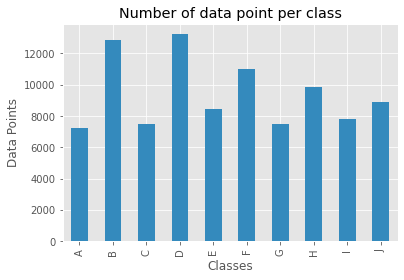

In [3]:
# data distribution per class

print('Class D and B have the highest number of datapoints')

df['Class'].value_counts().sort_index().plot(kind='bar', title='Number of data point per class',color='C1')
plt.ylabel('Data Points')
plt.xlabel('Classes')

## Model Architecture

The architecture of the deep LTSM model is a two hidden layer network with 160 neurons in the first hidden layer and 200 neurons in the second hidden layer. 

Fortunately, the authors provided us with their model which we can use as inspiration to start off our search!

The model .config() can be commented out for more information on the exact settings. For example, we can find out which dropout rate the authors used.

In [4]:
author_model = load_model('Model_clean_binary_cross_ICTAI_vehicle2_1')
author_model.summary()

2022-04-06 09:05:44.926869: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 160)         116480    
                                                                 
 batch_normalization_3 (Batc  (None, None, 160)        640       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, None, 160)         0         
                                                                 
 lstm_4 (LSTM)               (None, 120)               134880    
                                                                 
 batch_normalization_4 (Batc  (None, 120)              480       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 120)               0

In [5]:
# comment out this line to obtain model setup
# author_model.get_config()

## Fitting Data

The original idea was to use the criteria mentioned on Brightspace however, the code didn't fully run therefore we created our own model so we could run it. Next to this, we will also apply a hyperparameter check and ablation study.

### Preprocessing

In [15]:
# prepare features and classes
X, y = pre_process_encoder(df)

In [16]:
# partition the data with windows and assign it to train or test
X_train, y_train, X_test,y_test = rnn_dimension(X,y)

In [17]:
# normalize the data (very important)
X_train_scaled = normalizing(X_train)
X_test_scaled = normalizing(X_test)

### Hyperparameter
Right now, the overall context of the data is pretty clear. It's time to start building models and fitting it to the data. 

The build_model() function is used to do hyperparameter checking. We'll also use keras tuner to automatically search for the best model.

In [18]:
# import keras packages
from keras.layers import Dense, Dropout, LSTM, Activation, Flatten
from keras_tuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# import other packages

# build_model is a function that is defined underneath here right?
# import build_model 
import pathlib
from keras import callbacks


In [19]:
# create validation set for hyperparameter checking
X_val, X_test, y_val, y_test = train_test_split(X_test_scaled, y_test, test_size=0.7, random_state=1)

In [20]:
# instantiate hyperparameter object
# this will be passed to the build_model() function
hp = HyperParameters()

In [21]:
# build model
def build_model(hp):
    """ 
    Build model for dynamic hyper parameter training.
    input: hp "object" (HyperParameters() from kerastuner.engine.hyperparameters)
    """
    
    # Create sequential model
    model = Sequential()

    # HyperParameters
    activations = hp.Choice("activation", ["relu", "tanh"])
    # dropouts    = hp.Float("dropout", min_value=0.3, max_value=0.6, step=0.05)
    dropouts    = 0.5
    optimizers  = hp.Choice("optimizer", ["adam", "sgd"])
    units       = hp.Int("units", min_value=140, max_value=220, step=10)

    # first LSTM layer
    model.add(LSTM(
        units=units, 
        input_dim=X_train.shape[2], 
        activation=activations, 
        return_sequences=True))

    # intermediate layers
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropouts))

    # 2nd LSTM layer
    model.add(LSTM(
        units=units, 
        input_shape=(X_train.shape[1],X_train.shape[2]), 
        activation= activations, 
        return_sequences=False))

    # intermediate layers
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropouts))

    # output layer
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers, metrics=['accuracy'])

    return model

In [22]:
# save data to training.csv during search
csv_logger = callbacks.CSVLogger('training.csv', append=True)

# specify path to save the search
path_save = pathlib.Path(str(pathlib.Path().parent.resolve()) + "/models")

# change project name
project_name = "search1"

# setup tuner
max_trials = 50

tuner = RandomSearch(
    build_model,
    objective = "val_accuracy",
    max_trials = max_trials,
    executions_per_trial = 1,
    directory = path_save,
    project_name= project_name,
    overwrite = False
)



In [35]:
# execute (may take several minutes/hours)
tuner.search(x=X_train_scaled, 
             y=y_train,
             epochs=7, 
             batch_size=21, 
             validation_data=(X_val, y_val),
            #  callbacks=[tf.keras.callbacks.TensorBoard(pathlib.Path(r'C:\Users\dicis\Desktop\models'))]
             callbacks=[csv_logger]
            )

Trial 3 Complete [00h 00m 17s]
val_accuracy: 0.7966101765632629

Best val_accuracy So Far: 0.7966101765632629
Total elapsed time: 00h 00m 54s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_models(num_models=5)

### Hyperparameter Study
After performing the search, we obtain a dataset with the trail_id, its corresponding hyperparameters, and the validation accuracy.
By performing data visualization and statistical analysis we can see which parameters are important for increasing the validation accuracy (the objective) and gain understanding in how sensitive the model is to the hyperparameters.

The search has produced over 50 different models with three hyperparameters: activation, optimizer, and units. See 'trials_hp' to understand the data_set for analysis.

In [6]:
# ----- read the data from ./models -----

# create trials_hp and trial_history for hyperparamater study
trials_hp = pd.DataFrame()
for trial_id in [name for name in os.listdir("./models/search") if "trial" in name]:
    trials_hp = trials_hp.append(pd.read_json('./models/search/' + str(trial_id) + '/trial.json')['hyperparameters'][1], ignore_index=True)

trials_hp['trial_id'] = np.array(['trial_' + str(i) for i in range(trials_hp.shape[0])])

trial_history = pd.read_csv('training.csv')
n = 0
first = True
lst = []
for i in trial_history['epoch']:
    
    if i == 0 and first == False:
        n = n + 1

    lst.append('trial_'+str(n))
    first = False

trial_history['trial_id'] = np.array(lst)

# merge data
trials_hp = pd.merge(trials_hp, trial_history[trial_history['epoch'] == trial_history['epoch'].max()], on='trial_id')        

In [7]:
trials_hp.head(5)

,activation,optimizer,units,trial_id,epoch,accuracy,loss,val_accuracy,val_loss
0,tanh,adam,185.0,trial_0,6,0.888989,0.331696,0.871940,0.376307
1,relu,adam,145.0,trial_1,6,0.846399,0.426909,0.898305,0.292728
2,relu,adam,205.0,trial_2,6,0.830441,0.453778,0.919021,0.216400
3,relu,sgd,170.0,trial_3,6,0.815879,0.507743,0.903955,0.252902
4,tanh,sgd,205.0,trial_4,6,0.881608,0.359867,0.907721,0.296064


Lets see how the number of models are distributed

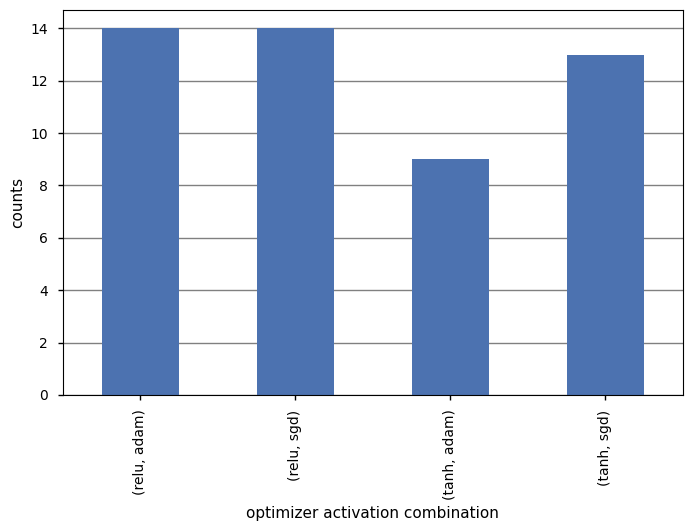

In [94]:
mpl.style.use('seaborn-deep')

fig, ax = plt.subplots(figsize=(8,5))

trials_hp[['activation', 'optimizer']].value_counts().sort_index().plot(kind='bar', title='Number of data points per model', ax=ax)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray')
plt.suptitle('')
plt.title('')
plt.xlabel('optimizer activation combination')
plt.ylabel('counts')
plt.show()

Lets plot the data with respect to the median accuracy, number of units, and also classify the points based on optimizer and activation function. \
In general, models using sgd & tanh appear to work better. However, this does not necessarily mean that the search will find the best model using this combination

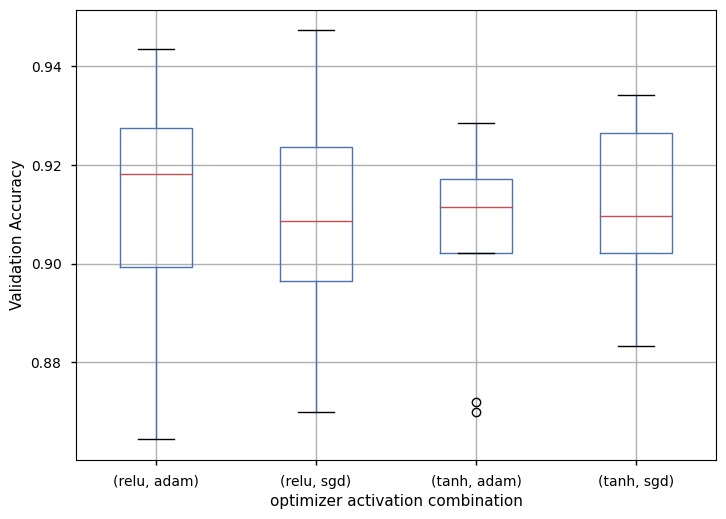

In [96]:
# mpl.style.use('seaborn-bright')

fig, ax = plt.subplots(figsize=(8,6))
trials_hp.boxplot(column=['val_accuracy'], by=['activation', 'optimizer'], ax=ax)
plt.suptitle('')
plt.title('')
plt.xlabel('optimizer activation combination')
plt.ylabel('Validation Accuracy')
plt.show()

Let's dive deeper in the different models.

The three parameters and objective value can all be visualized in one plot. Each point represent one trained model with the search. By carefuly analyzing the plot, 
we see that the relu activation functions either perform very bad or very good compared to the rest of the data. Another interesting insight is the fact that there is 
no strict correlation between the number of units and the validation accuracy. A model can still perform well on this data regardless of the number of units.

In [27]:
# correlation
print('relatively weak negative correlation')
trials_hp[['units', 'val_accuracy']].corr()

relatively weak negative correlation


,units,val_accuracy
units,1.000000,-0.030584
val_accuracy,-0.030584,1.000000


In [91]:
# pip install plotly
import plotly.express as px
fig = px.scatter(trials_hp, x='units', y='val_accuracy', color='activation', symbol='optimizer')
fig.show()

The models can also be compared based on the number of epochs. (this part still has to be finished)

In [29]:
df = pd.merge(trial_history, trials_hp[['activation', 'optimizer', 'units', 'trial_id']], on='trial_id')
df

,epoch,accuracy,loss,val_accuracy,val_loss,trial_id,activation,optimizer,units
0,0,0.443048,1.756191,0.602637,1.243153,trial_0,tanh,adam,185.0
1,1,0.673349,0.920970,0.817326,0.673794,trial_0,tanh,adam,185.0
2,2,0.765809,0.668693,0.887006,0.438549,trial_0,tanh,adam,185.0
3,3,0.812986,0.531935,0.881356,0.382570,trial_0,tanh,adam,185.0
4,4,0.843607,0.460407,0.911488,0.307887,trial_0,tanh,adam,185.0
...,...,...,...,...,...,...,...,...,...
345,2,0.699980,0.805823,0.809793,0.605748,trial_49,tanh,sgd,215.0
346,3,0.757431,0.665559,0.858757,0.401038,trial_49,tanh,sgd,215.0
347,4,0.797826,0.558888,0.900188,0.337164,trial_49,tanh,sgd,215.0
348,5,0.823758,0.494412,0.911488,0.283255,trial_49,tanh,sgd,215.0


In [ ]:
a_model = tuner.get_best_models(num_models=5)[3]

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model.fit(X_train_scaled, y_train, epochs=6, batch_size=21, shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

epochs = np.arange(1, len(best_model.history.history['loss']) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle('Train scores')

ax1.plot(epochs, best_model.history.history['loss'], 'o-')
ax1.set_ylabel('train_loss')

ax2.plot(epochs, best_model.history.history['accuracy'], '.-')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')

plt.show()

In [ ]:
best_model.save('./best_model')

In [ ]:
LSTM_model = load_model('./best_model')

## Reproducing fig 9
We are starting with reproducing figure 9, taken from the original paper:

<img src="original_figure9.png" alt="Graph showing 4 different classfiers' robustness to noise. LSTM is clearly the most robust" style="width: 500px;"/>

To do this, we first need the 4 different models shown (LSTM, FCNN, DecisionTree, RandomForest) in the graph. We use the LSTM that we found through the hyper parameter tuning above. The design of the FCNN that was likely used for this graph can be found in the code provided by the original author. The DecisionTree and RandomForest can be imported straight from keras. 

To start, we prepare the data again. This is done to keep everythhing contained a bit, and not use data that was prepared in a different part of the code. We load the data, one hot encode the labels and create train/test sets. Lastly, we scale the training and testing inputs.

In [244]:
# Get a clean copy of the data to make sure previous cells did not do something unexpected to the data
# As in the original paper, these model will be trained on the data without 'windows' (ie group of consecutive data points)
# This data will be marked as _nw (No Window) I do agree the names are getting a little long

df = pd.read_csv('./Data/korea_vehicledata.csv')
X_nw, y_nw = pre_process_encoder(df)

encoder = LabelEncoder()
encoder.fit(y_nw)
y_ints = encoder.transform(y_nw)  # A, B, C, ... --> 1, 2, 3, ...
y_dummy_nw = np_utils.to_categorical(y_ints)
X_train_nw, X_test_nw, y_train_nw, y_test_nw =train_test_split(X_nw, y_dummy_nw, train_size=0.85)
X_train_scaled_nw = normalizing_2d(X_train_nw)
X_test_scaled_nw = normalizing_2d(X_test_nw)


We import the layers we need (some were already imported but for me it is nice to be able to run just this part - hence I import them again).
We also import some functions and classifiers from sklearn.

In [245]:
from keras.layers import Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

We start by creating the FCNN, by adapting (but mainly copying) the code from the author and fitting it on the training data.

In [246]:
FCNN_model = Sequential()
# FCNN_model.add(Flatten())  # Flatten the input data so it can be passed through the dense layer
FCNN_model.add(Dense(160, input_dim=X_train_scaled_nw.shape[1], activation='relu'))
FCNN_model.add(layers.BatchNormalization())
FCNN_model.add(layers.Dropout(0.5))
FCNN_model.add(Dense(120, activation='relu'))
FCNN_model.add(layers.BatchNormalization())
FCNN_model.add(Dense(y_test_nw.shape[1], activation='softmax'))
# FCNN_model.add(Dense(1,activation='sigmoid'))
# FCNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
FCNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
with tf.device('/GPU:0'):
    FCNN_history = FCNN_model.fit(X_train_scaled_nw, y_train_nw, epochs=10,batch_size=100, shuffle=True)

Epoch 1/10
803/803 [==============================] - 5s 4ms/step - loss: 1.2338 - accuracy: 0.5514
Epoch 2/10
803/803 [==============================] - 3s 4ms/step - loss: 0.6483 - accuracy: 0.7581
Epoch 3/10
803/803 [==============================] - 4s 4ms/step - loss: 0.4791 - accuracy: 0.8220
Epoch 4/10
803/803 [==============================] - 3s 4ms/step - loss: 0.4007 - accuracy: 0.8532
Epoch 5/10
803/803 [==============================] - 4s 4ms/step - loss: 0.3503 - accuracy: 0.8734
Epoch 6/10
803/803 [==============================] - 3s 4ms/step - loss: 0.3175 - accuracy: 0.8834
Epoch 7/10
803/803 [==============================] - 3s 4ms/step - loss: 0.2914 - accuracy: 0.8935
Epoch 8/10
803/803 [==============================] - 4s 5ms/step - loss: 0.2670 - accuracy: 0.9031
Epoch 9/10
803/803 [==============================] - 4s 5ms/step - loss: 0.2473 - accuracy: 0.9108
Epoch 10/10
803/803 [==============================] - 4s 5ms/step - loss: 0.2268 - accuracy: 0.9183

We create a function to get the accuracy: it un-one-hot-encodes the predicted and true labels, and then get the accuracy. This will help to show if the DecisionTree and RandomForest are working as they should.

In [252]:
def test_accuracy(model, X, y):
    y_predict = model.predict(X)
    y_pred=np.argmax(y_predict, axis=1)
    y_test=np.argmax(y, axis=1)
    return metrics.accuracy_score(y_test, y_pred)



We now create a DecisionTree and RandomForest classifier. We also get their accuracies on both the test and training data to see if they are over or underfitting.


In [253]:
# Both the tree and forest are trained on the data WITHOUT windows
# Accuracy is higer that way then when training on data with windows (which is then reshaped)

print("### DecisionTree ###\n")
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train_scaled_nw, y_train_nw)

print("Training data accuracy:")
print(test_accuracy(DT_model, X_train_scaled_nw, y_train_nw))

print("Test accuracy:")
print(test_accuracy(DT_model, X_test_scaled_nw, y_test_nw))

print("\n### RandomForest ###\n")
RF_model = RandomForestClassifier(n_estimators=50)  # original paper uses 20 estimators
RF_model.fit(X_train_scaled_nw, y_train_nw)

print("Training data accuracy:")
print(test_accuracy(RF_model, X_train_scaled_nw, y_train_nw))

print("Test accuracy:")
print(test_accuracy(RF_model, X_test_scaled_nw, y_test_nw))

### DecisionTree ###

Training data accuracy:
1.0
Test accuracy:
0.9817757999576181

### RandomForest ###

Training data accuracy:
0.9999875347468931
Test accuracy:
0.9710390619481528


We now have the four models, but the LSTM and FCNN are not very well trained yet. Their accuracy is around 90% while the paper is closer to 100%. To fix this, we let them train for a bit longer. I suggest not to use this and just load the model:)

In [248]:
using_saved_model = True

if using_saved_model:
    FCNN_model_ = load_model('./FCNN_model_reproduce')
    LSTM_model = load_model('./LSTM_model_reproduce')
else:  # fit the models
    with tf.device('/GPU:0'):
        FCNN_history = FCNN_model.fit(X_train_scaled_nw, y_train_nw, epochs=150,batch_size=100, shuffle=True)
        FCNN_model.save('./FCNN_model_reproduce')
        # Make sure to train LSTM on 'windowed' data
        LSTM_history = LSTM_model.fit(X_train_scaled, y_train, epochs=150, batch_size=21, shuffle=False)
        LSTM_model.save('./LSTM_model_reproduce')

    

For a quick overview: these are the models' performance on the data without any noise

In [239]:
print(f"FCNN accuracy is {test_accuracy(FCNN_model, X_test_scaled_nw, y_test_nw)}")
print(f"LSTM accuracy is {test_accuracy(LSTM_model, X_test, y_test)}")
print(f"DecisionTree accuracy is {test_accuracy(DT_model, X_test_scaled_nw, y_test_nw)}")
print(f"RandomForest accuracy is {test_accuracy(RF_model, X_test_scaled_nw, y_test_nw)}")

FCNN accuracy is 0.6171505262414353
LSTM accuracy is 0.9378531073446328
DecisionTree accuracy is 0.4126580490216854
RandomForest accuracy is 0.25725789362153


Now that all models exist, we can start adding noise to the test data. To do this, we create function that takes NORMALIZED data and a standard deviation for the noise and returns the data with added noise.

In [240]:
def add_noise(data, sigma):        
    size_ = data.shape
    noise = np.random.normal(0, sigma, size=size_) # 1000 samples with normal distribution
    return data+noise



To show that the function works, we print the difference between some data before and after the noise function.


In [241]:
print((add_noise(X_train_scaled_nw, 1) - X_train_scaled_nw)[0])

[ 0.12293703 -0.48958351  0.98242962 -0.14770996  0.72822602  0.58351936
 -0.44160971 -0.20891797  0.226717    1.80536016  1.35391289 -1.49169915
 -1.57706254 -0.49402458 -0.35446895  1.63185853 -1.8127751   1.54201829
 -1.3346066   0.28531054  0.68101583 -0.19884329 -1.07003639  1.3937769
  2.52821343  0.66500026  1.31355427  1.40451657 -1.33391794  1.02715197
  1.60644385  0.24819514  0.43778317  0.95166043 -0.40778039 -0.38825723
  0.05215606 -0.21343535 -0.96813967  0.12072641 -0.7639576  -1.62400056
 -0.65162017  0.00880539 -0.11087607  0.18846292 -0.41202447 -0.97264991
 -0.80642138 -0.3376147   0.1589283  -0.57877558 -0.85446733]


We can now loop through increasing amounts of noise and get the accuracy for each noisy data.

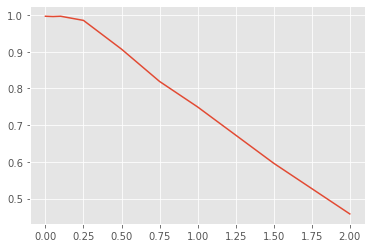

In [249]:
standard_deviation = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2]
accuracy = []

for sigma in standard_deviation:
    X_noisy = add_noise(X_test, sigma)
    accuracy.append(test_accuracy(LSTM_model, X_noisy, y_test))

plt.plot(standard_deviation, accuracy)

We can put this in a function, and call it for each model.

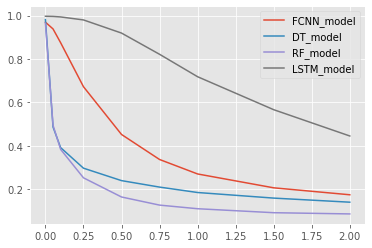

In [251]:
def noise_robustness(model, X, y, standard_deviations):
    accuracies = []

    for sigma in standard_deviations:
        X_noisy = add_noise(X, sigma)
        accuracies.append(test_accuracy(model, X_noisy, y))

    return standard_deviations, accuracies


standard_deviation = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2]

# These models use the same training data, so they can be called in a loop:
for model, label in zip([FCNN_model, DT_model, RF_model], ["FCNN_model", "DT_model", "RF_model"]):
    plot_data = noise_robustness(model, X_test_scaled_nw, y_test_nw, standard_deviation)
    plt.plot(plot_data[0], plot_data[1], label=label)

plot_data = noise_robustness(LSTM_model, X_test, y_test, standard_deviation)
plt.plot(plot_data[0], plot_data[1], label="LSTM_model")

plt.legend()
plt.show()

## Reproducing fig 10

To reproducde figure 10, we train the models ond data with noise. We then test the models on noisy data to see how they compare.

In [254]:
# It is unclear from the report if the same models are fitted or if he adds noisy data to the trained models.
# We continue with the trained models.

if using_saved_model:
    LSTM_model = load_model('./LSTM_model_noise')
    FCNN_model = load_model('./FCNN_model_noise')
else:
    # SD = 1 for the noise
    X_noise_nw = add_noise(X_train_scaled_nw, 1)

    FCNN_model.fit(X_noise_nw, y_train_nw, epochs=50)
    FCNN_model.save('./FCNN_model_noise')

    DT_model.fit(X_noise_nw, y_train_nw)
    RF_model.fit(X_noise_nw, y_train_nw)

    X_noise = add_noise(X_train_scaled, 1)

    LSTM_model.fit(X_noise, y_train, epochs=50)
    LSTM_model.save('./LSTM_model_noise')

Epoch 1/50
2507/2507 [==============================] - 8s 3ms/step - loss: 2.0201 - accuracy: 0.3051
Epoch 2/50
2507/2507 [==============================] - 8s 3ms/step - loss: 1.8099 - accuracy: 0.3362
Epoch 3/50
2507/2507 [==============================] - 9s 3ms/step - loss: 1.7771 - accuracy: 0.3460
Epoch 4/50
2507/2507 [==============================] - 9s 4ms/step - loss: 1.7600 - accuracy: 0.3526
Epoch 5/50
2507/2507 [==============================] - 9s 4ms/step - loss: 1.7470 - accuracy: 0.3571
Epoch 6/50
2507/2507 [==============================] - 8s 3ms/step - loss: 1.7406 - accuracy: 0.3595
Epoch 7/50
2507/2507 [==============================] - 7s 3ms/step - loss: 1.7306 - accuracy: 0.3641
Epoch 8/50
2507/2507 [==============================] - 7s 3ms/step - loss: 1.7265 - accuracy: 0.3656
Epoch 9/50
2507/2507 [==============================] - 7s 3ms/step - loss: 1.7198 - accuracy: 0.3670
Epoch 10/50
2507/2507 [==============================] - 8s 3ms/step - loss: 1.717

The trained models are then tested on data with noise (SD =1)

<BarContainer object of 4 artists>

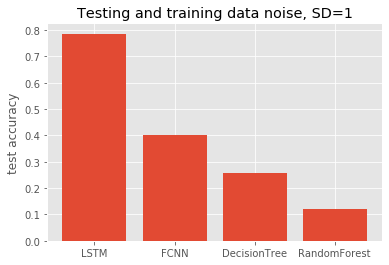

In [258]:
standard_deviation = [1]

models = [FCNN_model, DT_model, RF_model]

accuracies = []

_, accuracy = noise_robustness(LSTM_model, X_test, y_test, standard_deviation)
accuracies.append(accuracy[0])

# These models use the same training/testing data, so they can be called in a loop:
for model in models:
    _, accuracy = noise_robustness(model, X_test_scaled_nw, y_test_nw, standard_deviation)
    accuracies.append(accuracy[0])



names = ["LSTM", "FCNN", "DecisionTree", "RandomForest"]


plt.title("Testing and training data noise, SD=1")
plt.ylabel("test accuracy")
plt.bar(names, accuracies)